# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = 100 m  


#### Subsurface Properties: 
- Homogeneous for top and bottom layers
- K = 10.0 m/day in x,y and in z.  
- Homogeneous for middle layer
- K = 10.0 m/day in x and y and 0.0001 m/day in z.
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2100, 3800)
     - Pumping at a rate of 1500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz= 10m/d for the leftmost 20 columns, but it is 0.0001 m/day in the z direction in the rest columns
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [245]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [246]:
## model directory
moddir="C:/Users/hassa/Documents/GW_Modelling_Hassan/homework-Hassan-H1/Working/mf2005"
## Discretization
nrow = 50     # number of rows
ncol = 50     # number of columns
nlay = 1      # number of layers

dx= 1000      # width of grid cells in x direction 
dy= 1000      # width of grid cells in y direction 

Lx = ncol*dx  # width of domain in x
Ly = nrow*dy  # width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

# print(type(ztop))
#print(ztop.shape)
# print(ztop[0,:])
zbot = 0.                 # bottom elevation

dz = (ztop - zbot) / nlay # cell height in z direction

## Timing
nper = 1        # number of stress periods 
steady = [True] # list noting the stress period type

## Subsurface properties
K_horiz = 10   # assign horizontal hydraulic conductivity 
K_vert = 10    # assign vertical hydraulic conductivity (along z axis)
n = 0.1        # assign porosity
Ss = 0.0001    # assign storage coefficient
Sy = 0.1       # assign specific yield
uncnf = 1      # 0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 # #m/day

## Well
pumping = 0                                   # pumping well rate -1500 m3/day  given
well_xy= [21000, 38000]                       # xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) # convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1)            # convert the x location to a column
well_loc = (2,well_row,well_col)              # Well loc should be layer, row, column
print(well_loc)
#print(well_col)


## Boundary conditions
h_left = 95
h_right = 70

(2, 11.0, 20.0)


## 4. Setup and run MODFLOW for the three layer scenario 

# Setup the stream! Define STR object

In [247]:
#Initialize the model
modelname3 = "ThreeLayer"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

## Make some changes to the parameters
nlay2=3  #three layers instead of 1
botm = np.zeros((nlay2,nrow,ncol))   # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                    # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                    # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = 0.0001               # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[0,:,:] = 0.0001                  # Replace the K in the middle layer with the lower value
Kh[0,:,:] = 1                        # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay2, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay2, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:,:,0] = 0            #replace leftmost column (all zs, all ys, first x) with 0 to indicate inactive cell
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

#..........................................................................................
# assign the no flow cells for the top layer, extended from [0,0] to [5,5]
nn1 = 6

for ii in range(nn1):
     # internal loop run for i-1 times
     for k in range(0, nn1-ii):
        ibound[0,ii,k] = 0

mm1 = 5       
for jj in range(mm1+1):
    # internal loop run for i times
         for kk in range(0, jj+1):
             ibound[0,((nrow-nn1)+jj),kk] = 0
#..........................................................................................
# assign the no flow cells for the middle layer, extended from [0,0] to [7,7]
nn2 = 8

for ii in range(nn2):
     # internal loop run for i-1 times
     for k in range(0, nn2-ii):
        ibound[1,ii,k] = 0

mm2 = 7       
for jj in range(mm2+1):
    # internal loop run for i times
         for kk in range(0, jj+1):
             ibound[1,((nrow-nn2)+jj),kk] = 0
#............................................................................................
# assign the no flow cells for the top layer, extended from [0,0] to [9,9]
nn3 = 10

for ii in range(nn3):
     # internal loop run for i-1 times
     for k in range(0, nn3-ii):
        ibound[2,ii,k] = 0

mm3 = 9       
for jj in range(mm3+1):
    # internal loop run for i times
         for kk in range(0, jj+1):
             ibound[2,((nrow-nn3)+jj),kk] = 0
#.............................................................................................. 

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay2, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right     # initialize the entire domain to the right head value
H_init[:, :, -1] = h_right    # replace first (left) col with desired head value

bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((1,nrow,ncol))               # define an array of zeros of dim (nrow,ncol)
rech_zone[:,:,0:15]=rech_zone[:,:,0:15]+recharge                    # assign recharge value to the domain  
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     # create rch object

#Well
well_loc = (2,well_row,well_col) # Well loc should be layer, row, column (assigned to the bottom layer)
well_1 = [i for i in well_loc] + [pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]} # putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
bkgndET = 1e-5                      # set background ET value m/day 
ET_zone[:,25:49]=  bkgndET          # assign ET value m/day for the right half of the domain                      
ET_zone[22:28,:]=  5e-5             # assign ET value m/day in the riparian area, accupies row 22 to 28, extended from the left to right boundary
extinction_depth = 1

evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 
                            

[2, 11.0, 20.0, 0]
Well 1 [layer, row, column, flux]: 
 [2, 11.0, 20.0, 0]


# No Ag No Town senario (NTNA)

In [248]:
#1. Setup the stream characteristics 
Kstream = 10              # stream bed hydraulic conductivity in f/d
sed_thick = 1               # thickness of riverbed sediment in f
slope = 0.001               # slope of streambed (m/m)
rough = 0.04                # roughness of streambed
width = 20.                 # x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
Stage = 0.5                 # top of streambed is at 8 m (incl 1 m of streambed thickness)
nseg = 3
ntrib = 2
# str settings
set_icalc = 1               # 1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []               # create list to store all river cells for stress period 1
const = 86400.0             # multiplication constant for m3/day - see documentation for other units
istcb2 = 53                 # save outflows to cbb file


#.........................................................................................................................
#2. Calculate the streambed conductance 

cond = Kstream*(width)*(dy)/(sed_thick)  # Calculate the streambed conductance 
cond_vals = np.ones(ncol) *cond
cond_vals[0:20] = cond
cond_vals[21:26] = cond
cond_vals[27:-1] = cond
#..........................................................................................................................
#3. Setup the reach locations stream segment numbers and reach numbers
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50                                    # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)                  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn = 0#50                                  # return flow from the town
return_loc = 25                                 # specifying the column where the town return flows come in
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn                # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1                   # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)     # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2                        # Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3               # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)                 # create an array of reach #s counting from 1-50
reaches[return_loc] = 1                         # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1


str_bott = 7   # Elevation of the river bottom str_top = str_bott+sed_thick. # Elevation of streambed top
str_stage = 9  # doesn’t matter what we se this to if icalc is >0
str_top = str_bott+sed_thick

if set_icalc > 0:      # Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)
#..........................................................................................................................
#4. Setup the elevation of the streams

#ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))                            # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.        # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick       # elevation of the bottom of the streambed (m)
stage_elev = Stop + Stage     # elevation of the water surface in the stream (m)

strd = {} 
strspd = []
for y in range(ncol):
     add = [0, y, nrow/2, 1, y+1, Flow_into_the_1st_reach, str_stage, cond_vals[y], str_bott, str_top,  width, slope, rough]
strspd.append(add)
strd[0]=strspd 
#...........................................................................................................................
#5. Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], Kstream, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary
#............................................................................................................................

#6. Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
#seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary
#..............................................................................................................................
#7. Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')
print('elevation of the top of the streambed',Stop)
print('elevation of the bottom of the streambed ',Sbot)
print('elevation of the water surface in the stream ',stage_elev)
print(' -surface water elevation > elevation of the top of the stream > elevation of the bottom of the stream')


Calculated stage at inflow = 8.0
elevation of the top of the streambed [99.  98.  97.  96.  95.  94.  93.  92.  91.  90.  89.  88.  87.  86.
 85.  84.  83.  82.  81.  80.  79.  78.  77.  76.  75.  74.9 74.8 74.7
 74.6 74.5 74.4 74.3 74.2 74.1 74.  73.9 73.8 73.7 73.6 73.5 73.4 73.3
 73.2 73.1 73.  72.9 72.8 72.7 72.6 72.5]
elevation of the bottom of the streambed  [98.  97.  96.  95.  94.  93.  92.  91.  90.  89.  88.  87.  86.  85.
 84.  83.  82.  81.  80.  79.  78.  77.  76.  75.  74.  73.9 73.8 73.7
 73.6 73.5 73.4 73.3 73.2 73.1 73.  72.9 72.8 72.7 72.6 72.5 72.4 72.3
 72.2 72.1 72.  71.9 71.8 71.7 71.6 71.5]
elevation of the water surface in the stream  [99.5 98.5 97.5 96.5 95.5 94.5 93.5 92.5 91.5 90.5 89.5 88.5 87.5 86.5
 85.5 84.5 83.5 82.5 81.5 80.5 79.5 78.5 77.5 76.5 75.5 75.4 75.3 75.2
 75.1 75.  74.9 74.8 74.7 74.6 74.5 74.4 74.3 74.2 74.1 74.  73.9 73.8
 73.7 73.6 73.5 73.4 73.3 73.2 73.1 73. ]
 -surface water elevation > elevation of the top of the stream > elevation of 

# Run the model with PCG solver 

In [249]:
#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)
#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/hassa/Documents/GW_Modelling_Hassan/homework-Hassan-H1/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 15:27:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 15:27:28
 Elapsed run time:  0.121 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

Figure1: shows the top left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [5,5])


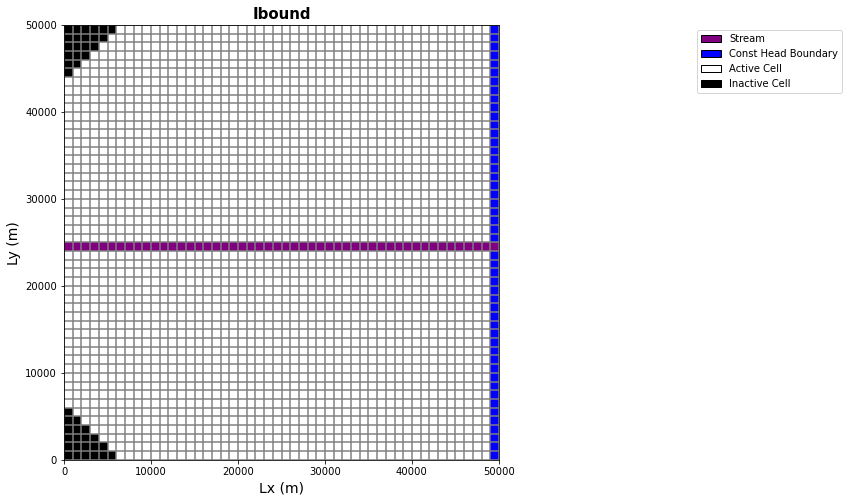

Figure2: shows the middle left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [7,7])


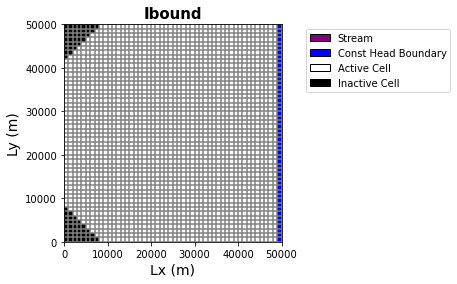

Figure3: shows the top left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [9,9])


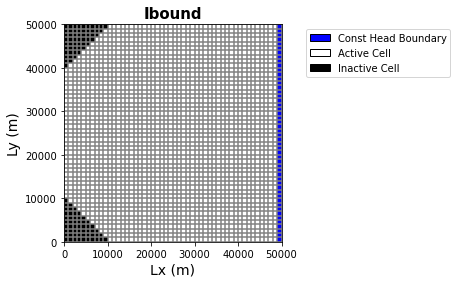

In [250]:
# Top layer mapview grid + stream
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
print('Figure1: shows the top left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [5,5])')

# Middle layer mapview grid
plt.show(modelmap)
modelmap2 = flopy.plot.PlotMapView(model=m3, layer=1)
grid = modelmap2.plot_grid()
ib = modelmap2.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
#str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
print('Figure2: shows the middle left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [7,7])')
# Bottom layer mapview grid                
plt.show(modelmap2)
modelmap3 = flopy.plot.PlotMapView(model=m3, layer=2)
grid = modelmap3.plot_grid()
ib = modelmap3.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
#str_m = modelmap3.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0)) 
print('Figure3: shows the top left and bottom left corners of the domain rounded by bedrocok, which assigned as no flow cells (frm [0,0] to [9,9])')                                     
#plt.show(modelmap)
#plt.savefig('grid for top.jpg')


plt.show(modelname3)
 

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

Figure4: a cross-section parrallel to the stream, along the aquifer length (x-direction). showing the three layers


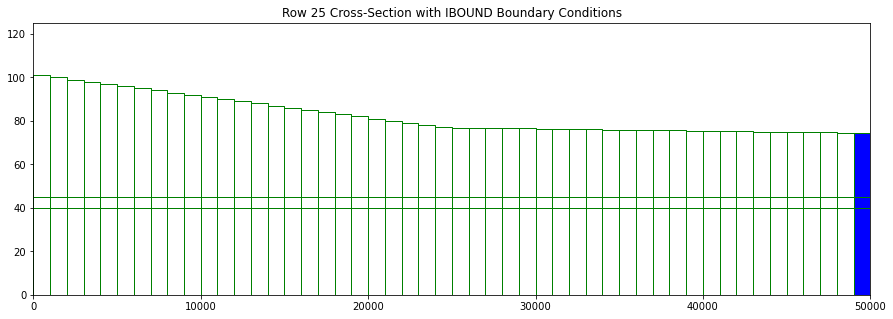

In [251]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
plt.savefig('cross-section of layered model change top.jpg') 
print('Figure4: a cross-section parrallel to the stream, along the aquifer length (x-direction). showing the three layers')

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [252]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 
#leak = head1#budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 
#str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 
#head = head1#headobj1.get_data(totim=1.0)

#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj3.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 8. Plotting the Results
### 8.1 Cross section plots

fiogure5: shows the water level in the three layers in corssection along the flow path, to downstream (x-direction)


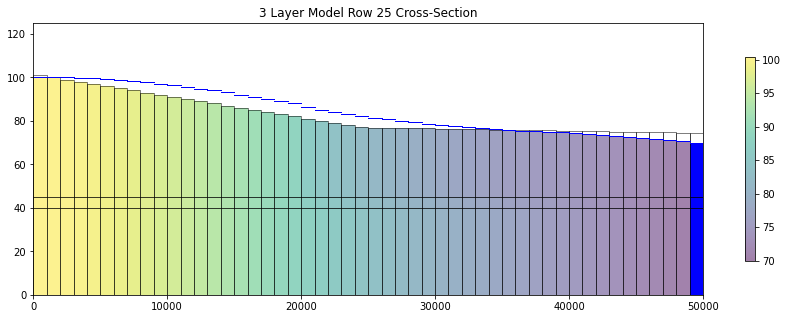

In [253]:

#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[-999.99], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[-999.99], color='blue', lw=1)
print('fiogure5: shows the water level in the three layers in corssection along the flow path, to downstream (x-direction)')
#print(head3[0,:,:])

# Plot stream related results

# 9. Additional plots
### 9.1 Plot head transect

Figure6: shows the first senario where no agricultural activity or twon wter usage apply
- we see that the water level is the same in all three layers 


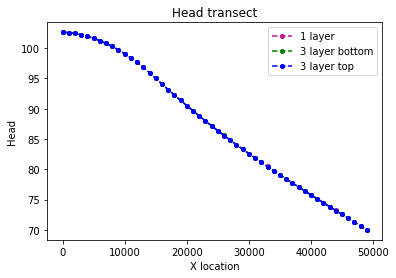

In [254]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,50000,1000) 
plt.plot(x,head3[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3[1,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.plot(x,head3[2,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()
print('Figure6: shows the first senario where no agricultural activity or twon wter usage apply')
print('- we see that the water level is the same in all three layers ')
# plt.savefig('Head_Transect.png')

# Plot stream related results 

Figure7:shows groundwater head in the domain (cells) below the water level in the streambed
-this is an indecation of water loss (recharge) from stream to the aquifer


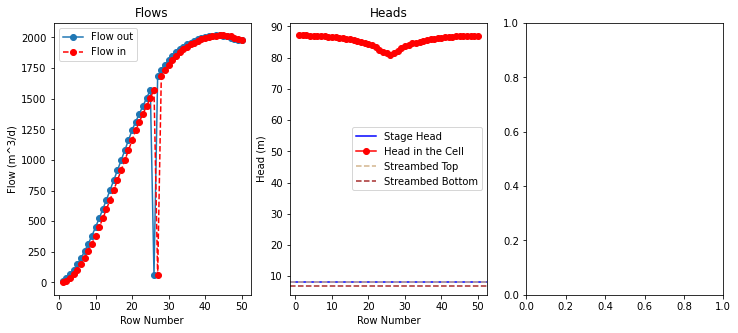

In [255]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname3+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='o') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='o') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()
plt.savefig('reach wise water budget.jpg') 
#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='o') 
ax2.axhline(y=str_top,  color='tan', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()
plt.savefig('reach wise head.jpg') 
print('Figure7:shows groundwater head in the domain (cells) below the water level in the streambed')
print('-this is an indecation of water loss (recharge) from stream to the aquifer')

###  Bottom Layer Head Contours

C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


Figure9: shows a contour head map and the flow velocity field 
- The half left sides of the doman shws no flow twards downstream
- The right half domain of the model shows water flow towards the right boundry
- Since this is the bottom layer, no ET effects the water level (ET extended depth = 1m)
- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream


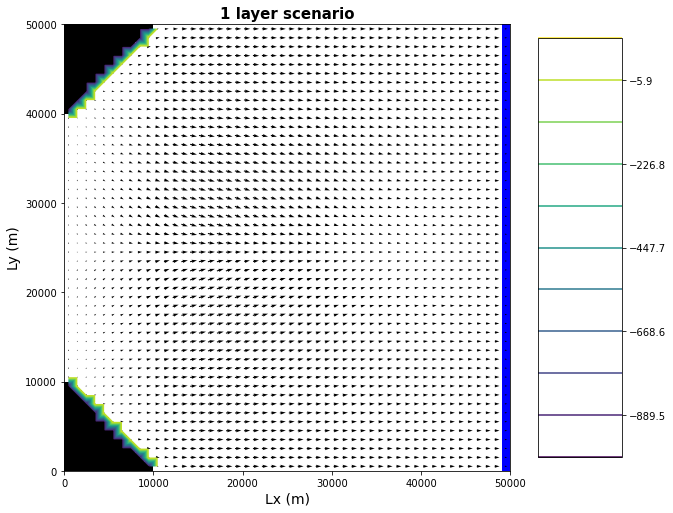

In [256]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
print('Figure9: shows a contour head map and the flow velocity field ')
print('- The half left sides of the doman shws no flow twards downstream')
print('- The right half domain of the model shows water flow towards the right boundry')
print('- Since this is the bottom layer, no ET effects the water level (ET extended depth = 1m)')
print('- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream')
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')

### Middle Layer Head contour

C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


Figure10: shows a contour head map and the flow velocity field 
- almost 3/4  of the doman shows no flow towards downstream
- The 1/4 right  domain of the model shws water flow twards the right boundry
- Since this is the middle layer, no ET effects the water level (ET extended depth = 1 m)
- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream


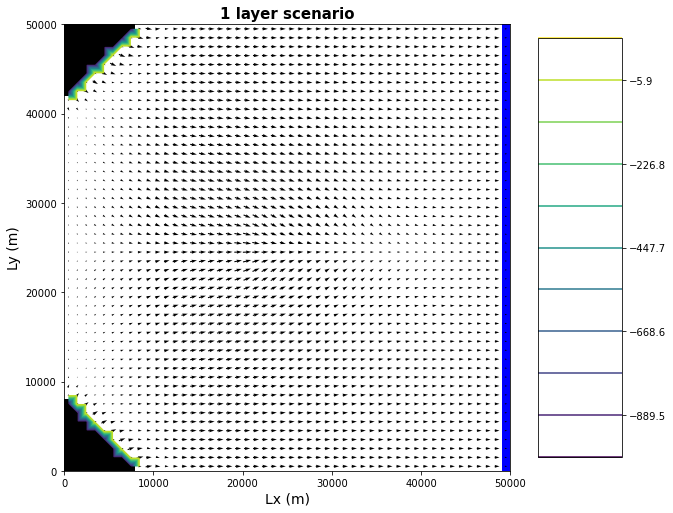

In [257]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m3, layer=1) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')
print('Figure10: shows a contour head map and the flow velocity field ')
print('- almost 3/4  of the doman shows no flow towards downstream')
print('- The 1/4 right  domain of the model shws water flow twards the right boundry')
print('- Since this is the middle layer, no ET effects the water level (ET extended depth = 1 m)')
print('- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream')

### Top Layer head contours

C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\hassa\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


Figure10: shows a contour head map and the flow velocity field 
- almost major part  of the doman shows no flow towards downstream
- Less than 1/4 right  domain of the model shws water flow twards the right boundry
- Since this is the upper layer, ET effects the water level (ET extended depth = 1 m)
- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream


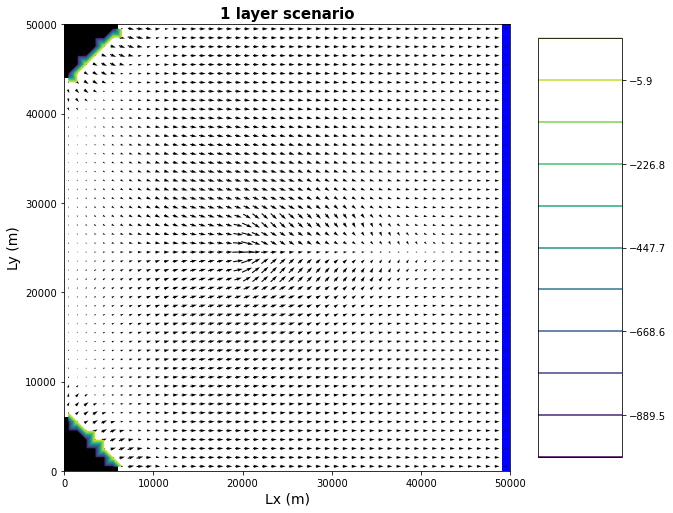

In [258]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')
print('Figure10: shows a contour head map and the flow velocity field ')
print('- almost major part  of the doman shows no flow towards downstream')
print('- Less than 1/4 right  domain of the model shws water flow twards the right boundry')
print('- Since this is the upper layer, ET effects the water level (ET extended depth = 1 m)')
print('- On the hand, due to the small amount of recharge, the water level in this layer did not change or responce to stress from the stream')